Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
- Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log

In [ ]:
#1. Load the data
movie=pd.read_csv("../data/movie_metadata.csv")

2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

In [88]:
movie.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


3 Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

5 Determine the baserate or prevalence for the classifier, what does this number mean?

6 Split your data into test, tune, and train. (80/10/10)

In [ ]:
#Steps 2-6 are done in the following function:

# Function drops unnecessary columns, fills in missing vals with mean, creates the score column with the binned imdb values, and creates the train/test/tune splits
def clean_split_data(df, target, train_size=0.80, tune_size=0.10, random_state=21):
    # Split independent and dependent variables
    df = df[['num_critic_for_reviews','actor_1_facebook_likes','gross','num_voted_users','cast_total_facebook_likes','num_user_for_reviews','budget','imdb_score','movie_facebook_likes']]
    df['score'] = pd.cut(df['imdb_score'], bins=[0, 5, 7, 10], labels=['low', 'medium', 'high'])
    df = df.drop(columns=['imdb_score'])
    df = df.fillna(df.mean(numeric_only=True))
    X = df.drop(columns=target)
    y = df[target]
    
    # Calculate prevalence of the score
    prevalence = y.value_counts(normalize=True)
    print("Prevalence of Imdb scores groups by range:\n", prevalence)
    
    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the movie data
X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(movie, 'score')

Prevalence of Imdb scores groups by range:
 score
medium    0.580012
high      0.316082
low       0.103906
Name: proportion, dtype: float64


/tmp/ipykernel_2299/2415988121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = pd.cut(df['imdb_score'], bins=[0, 5, 7, 10], labels=['low', 'medium', 'high'])


7 Create the kfold object for cross validation.

In [90]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)

8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter (grid search) 

In [ ]:
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']

param={"max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        #"splitter":["best","random"],
        #"min_samples_split":[5,10,15,20,25],
        #"min_samples_leaf":[5,10,15,20,25],
        #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        #"max_features":["auto","log2","sqrt",None],
        #"max_leaf_nodes":[10,20,30,40,50],
        #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
        #'ccp_alpha' :[.001, .01, .1]
           }

9 Build the classifier object 

In [92]:
cl= DecisionTreeClassifier(random_state=1000)

10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [93]:
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy')

11 Fit the model to the training data.

In [94]:
model = search.fit(X_train, y_train)

12 What is the best depth value?

In [95]:
best = model.best_estimator_
print(best)
#It seems the best depth value is 18

DecisionTreeClassifier(max_depth=18, random_state=1000)


13 Print out the model

DecisionTreeClassifier(max_depth=18, random_state=1000)


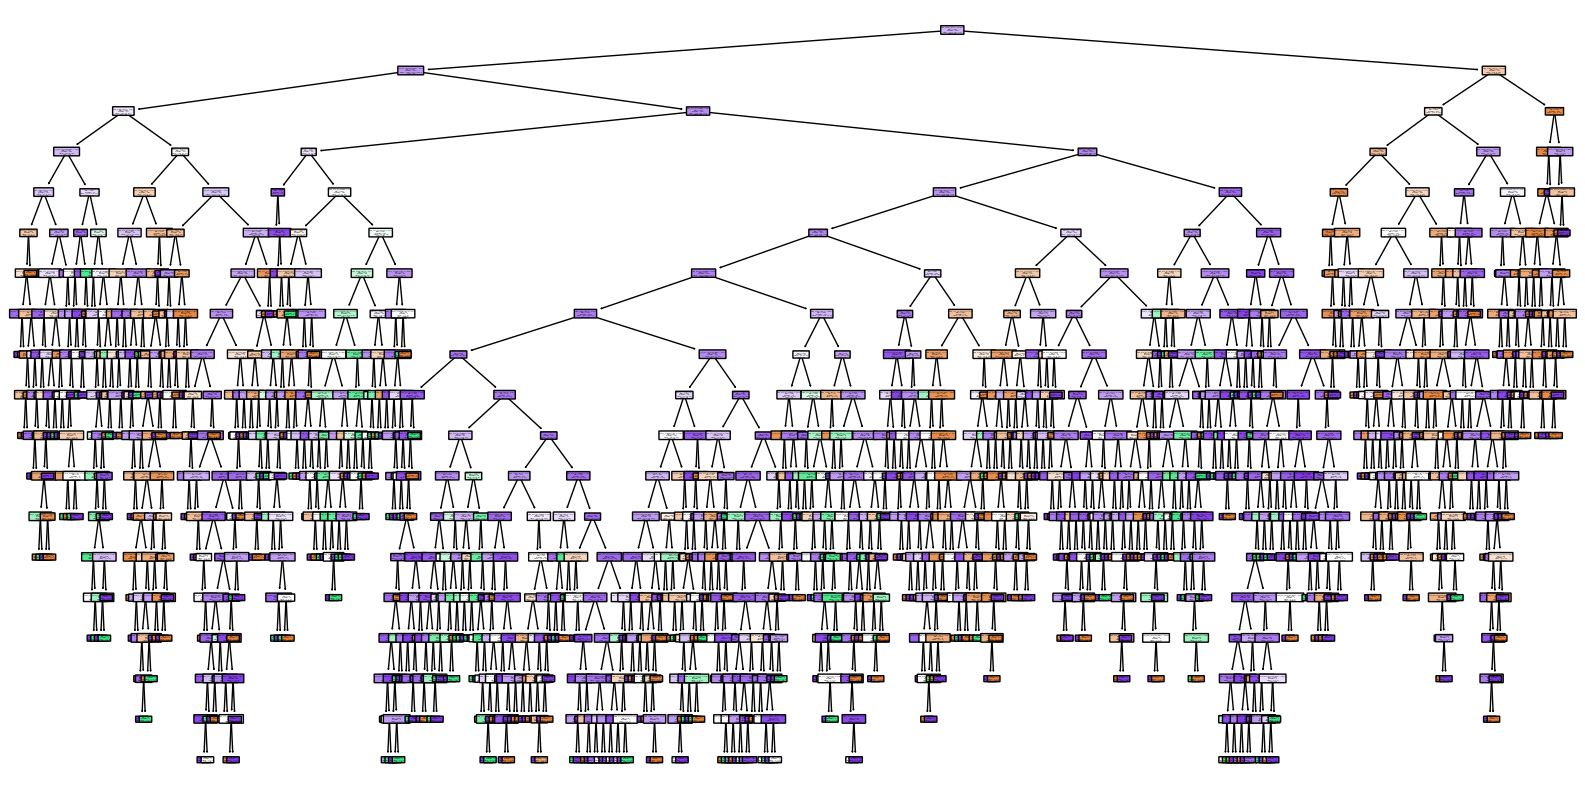

In [96]:
best = model.best_estimator_
print(best)

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=y_train.unique(), filled=True, rounded=True)
plt.show()

In [105]:
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model.head())

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1     0.578  0.381222  0.381222  0.347646    0.144624  0.116883   
1      2     0.598  0.401556  0.401556  0.367740    0.127264  0.089980   
2      3     0.552  0.426889  0.426889  0.391295    0.162776  0.181908   
3      4     0.554  0.434444  0.434444  0.411692    0.176873  0.172791   
4      5     0.556  0.475333  0.475333  0.443758    0.174539  0.190963   

   bal_accSD      f1SD  
0   0.116883  0.122716  
1   0.089980  0.103217  
2   0.181908  0.163147  
3   0.172791  0.169772  
4   0.190963  0.186506  


14 View the results, comment on how the model performed using the metrics you selected.

It seems that the model is overfitting, as the depth is very large which may indicate a model that is too complexly formed on the training data and will not be able to handle new data accurately. 

15 Which variables appear to be contributing the most (variable importance) 

                           importance
num_voted_users              0.221250
budget                       0.132081
cast_total_facebook_likes    0.128620
num_user_for_reviews         0.125612
gross                        0.122346
num_critic_for_reviews       0.117863
movie_facebook_likes         0.079169
actor_1_facebook_likes       0.073060


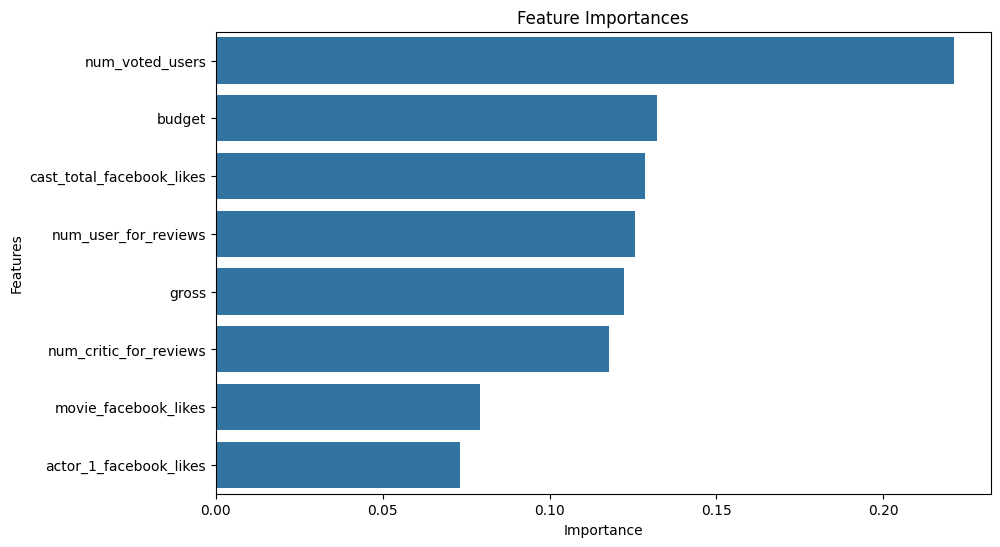

In [98]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
# It seems that the most important feature is the num_voted_users, followed by the num_users_for_reviews.

16 Use the predict method on the tune data and print out the results.

In [99]:
tune_predictions = pd.DataFrame(model.predict(X_tune), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
    Label  Percentage
0  medium        71.0
1    high        28.0
2     low         1.0


17 How does the model perform on the tune data?

In [ ]:
model2 = search.fit(X_tune, y_tune)
best = model2.best_estimator_
print(best)

# The model seems to perform well as the depth has decreased to 5 showing that it can become accurate with less complexity and overfitting.

DecisionTreeClassifier(max_depth=5, random_state=1000)


18 Print out the confusion matrix for the tune data, what does it tell you about the model?

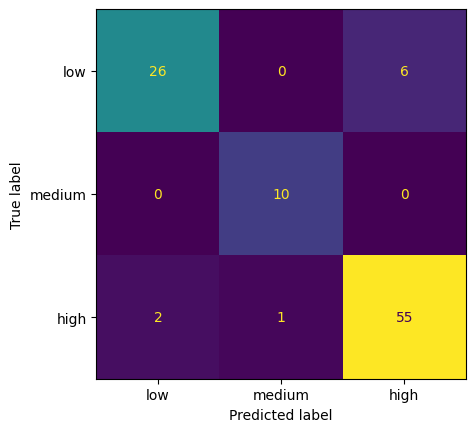

In [101]:
print(ConfusionMatrixDisplay.from_estimator(best, X_tune, y_tune, display_labels=['low', 'medium', 'high'], colorbar=False))

It shows that the model is doing very well at predicting the correct class, with only a false classifications in Predicted High but True Low. This suggests that the model is able to handle new data accurately and is not overfitting to the training data.

19 What are the top 3 movies based on the tune set? Which variables are most important in predicting the top 3 movies?

20 Use a different hyperparameter for the grid search function and go through the process above again using the tune set. 

DecisionTreeClassifier(max_depth=5, random_state=1000)


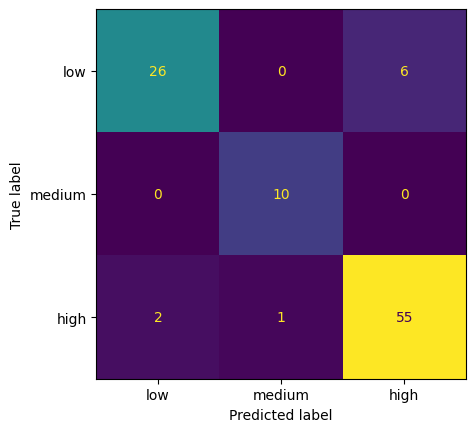

In [102]:
param1={
        'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]
           }

search1 = GridSearchCV(cl, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy')

model1 = search.fit(X_tune, y_tune)
best1 = model1.best_estimator_
print(best1)
print(ConfusionMatrixDisplay.from_estimator(best1, X_tune, y_tune, display_labels=['low', 'medium', 'high'], colorbar=False))

21 Did the model improve with the new hyperparameter search?

It does not seem that the model improved in altering the hyperparameter as it still went to the same depth as the previous model showing know further specification or accuracy. This is supplemented by the fact that the confusion matrix is the exact same for the new model showing it did not alter anything at all. 

22 Using the better model, predict the test data and print out the results.

In [103]:
tune_predictions = pd.DataFrame(model.predict(X_test), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
    Label  Percentage
0  medium   62.046205
1    high   27.062706
2     low   10.891089


23 Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.